In [1]:
%%capture
!pip install tensorflow-datasets==4.8 --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install pydot --quiet
!pip install transformers==4.17 --quiet
!pip install -U scikit-learn

In [2]:
#Tensorflow libiries
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds

#Transformers - BERT from huggingface
from transformers import BertTokenizer, TFBertModel
from transformers import logging
logging.set_verbosity_error()
from transformers import AutoConfig
from tensorflow.keras.callbacks import EarlyStopping

#NLP libiries
import sklearn as sk
from sklearn.metrics import classification_report
import os
import nltk
from nltk.data import find

#data process
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
import pandas as pd
import math
from bs4 import BeautifulSoup
import os
import json


In [3]:
#loading the pre-trained tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

In [12]:
#load the dataset with error handling
try:
    train_df = pd.read_csv('balanced_train_data(Revised)-2.csv')
except pd.errors.ParserError as e:
    print(f"Error reading CSV: {e}")
    # Print the lines around the problematic row
    with open('full_train_data(Revised).csv', 'r') as f:
        lines = f.readlines()
        for i in range(17622, 17626):
            if i < len(lines):
                print(lines[i])

test_df = pd.read_csv('balanced_test_data(Revised)-2.csv')

# Adjust pandas display settings to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full content of each column
pd.set_option('display.width', None)  # Auto-detect width of the display




In [13]:
train_df.head(1)

title        date  \
0  want shrink wage gap? help parent care kids.  2016-04-12   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [14]:
print(f"basic train_df info: ",train_df.shape)

basic train_df info:  (7740, 6)


In [15]:
test_df.head(1)

,title,date,content_original,bias,bias_text,source
0,opinion: party bad faith?,2017-07-17,"senate majority leader mitch mcconnell capitol hill (aaron p. bernstein/reuters) despite repeated promises, republican can’t seem repeal obamacare. if republican attempt repeal replace obamacare ultimately fails, lesson wage political bad faith. the bill plenty obstacles, including sheer inertia obamacare status quo fact one made public case republican legislation. effort also suffers mismatch longtime public posture republican (obamacare must fully repealed) private misgiving (do really this, even partially?). advertisement advertisement it’s republican said year would repeal obamacare; actually voted it. december 2015, bill passed senate stringent version struggling gop support. 2015 bill tried repeal obamacare (although fell short goal), current bill attempt repeal replace, i.e., forge republican alternative. only two republican senator voted 2015 repeal, susan collins maine, still no,” mark kirk illinois, senate. everyone else board, celebrated righteous blow obamacare. winston churchill said nothing exhilarating getting shot without consequence. republicans, nothing exhilarating repealing obamacare without consequence. the repeal bill inevitably got vetoed president barack obama. republican congressional leader thought could pick left off. failed account changed — difficult — dynamic republican white house ready eager sign whatever get desk. advertisement advertisement the prospect current bill clouded hesitance medicaid moderates, republican senator state accepted obamacare expansion program. legislation hardly dickensian front. allows state continue expansion, but, time, brings level federal funding new population level rest medicaid (years now, also establishes new per caput formula medicaid). 2015 law tougher expansion — simply ended two year — yet today’s handwringers voted it. perhaps disturbed coverage number congressional budget office produced current bill? according cbo, would lead 22 million fewer people insurance. earlier repeal bill, per cbo, would led 32 million fewer people insurance. advertisement perhaps think current bill generous? fact senate bill unveiled week ago spends roughly $600 billion replacing obamacare, $600 billion december 2015 bill. since revised spend even more, scale back tax cuts. advertisement a publication health affair starkly noted 2015 legislation time, would end premium tax credits, costsharing reduction payments, medicaid expansion, small business tax credit — is, assistance aca give low moderateincome americans.” (rand paul, whose shtick libertarian purity, guilty hypocrisy. portrays 2015 bill preferable current version, opposes fully repealing obamacare regulations. 2015 bill didn’t touch major obamacare regulations.) advertisement all plan b endorsed president donald trump — revert repealonly bill current bill fails — nonstarter. aren’t 50 republican vote today’s relatively generous bill, won’t 50 vote anything like passed year half ago. unless, perhaps, trump promise veto it, senate republican consider blissfully consequencefree vote. read more: if republican nothing obamacare, voter punish them republicans’ grim healthcare fairy tale the republican healthcare mistake — rich lowry editor national review. reached via email: comments.lowry@nationalreview.com. © 2017 king feature syndicate",2,right,Rich Lowry


In [16]:
print(f"basic test_df info: ",test_df.shape)

basic test_df info:  (3318, 6)


In [17]:
# extract the train and test text from both dataframes
train_text = train_df['content_original']
train_text_labels = train_df['bias']

validate_text = test_df['content_original'][0:1105]
validate_text_labels = test_df['bias'][0:1105]

test_text = test_df['content_original'][1105:]
test_text_labels = test_df['bias'][1105:]


print(f"size of training dataset: ",len(train_text))
print()
print(f"size of valid dataset: ",len(validate_text))
print()
print(f"size of testing dataset: ",len(test_text))
print()
print(f"Left with Label 0 ")
print(f"Center with Label 1 ")
print(f"Right with Label 2 ")

size of training dataset:  7740

size of valid dataset:  1105

size of testing dataset:  2213

Left with Label 0 
Center with Label 1 
Right with Label 2 


In [18]:
MAX_SEQUENCE_LENGTH = 512

In [19]:
# tokenize the dataset, truncate at `max_length`,

#tokenizing the train text
x_train = bert_tokenizer(train_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_train = train_text_labels

#tokenizing the validate text
x_validate = bert_tokenizer(validate_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_validate = validate_text_labels


#tokenizing the test text
x_test = bert_tokenizer(test_text.tolist(),
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
y_test = test_text_labels

In [20]:
#BERT base uncased model configurations
config = AutoConfig.from_pretrained('bert-base-uncased')

config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#BERT Uncase Model Fine-Tuning

In [21]:
def create_bert_classification_model(bert_model,
                                     num_train_layers=0,
                                     num_classes = 3,
                                     hidden_size = 768,
                                     dropout=0.2,
                                     attention_probs_dropout_prob = 0.1,
                                     hidden_dropout_prob=0.15,
                                     learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes
    """
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True

    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(num_train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)


        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    #pooler_token = bert_out[1]
    cls_token = bert_out[0][:, 0, :]

    hidden_1 = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_1')(cls_token)
    hidden_1 = tf.keras.layers.Dropout(dropout)(hidden_1)


    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden_1)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [22]:
#let's get a fresh instance of the bert_model -- good practice
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_classification_model = create_bert_classification_model(bert_model, num_train_layers=12)

In [23]:
#confirm all layers are frozen
bert_classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                      

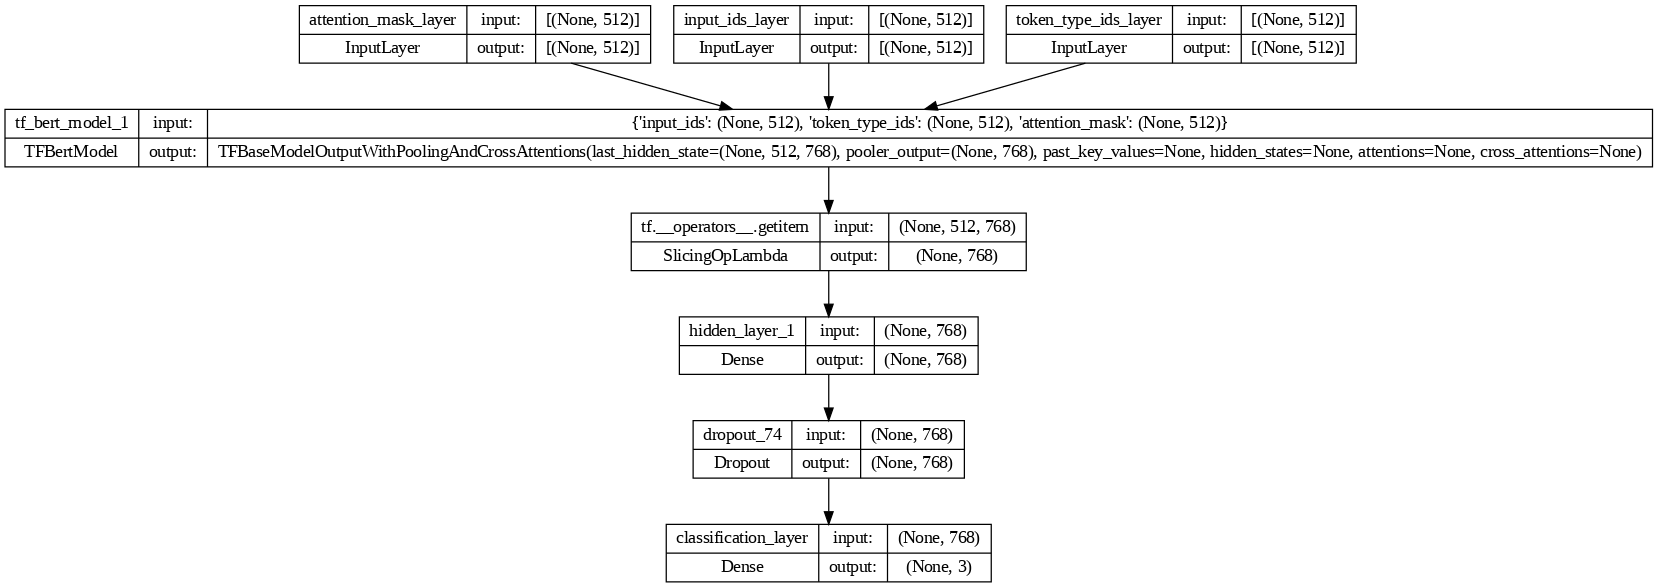

In [24]:
keras.utils.plot_model(bert_classification_model, show_shapes=True, dpi=90)

In [25]:
from tensorflow.keras.callbacks import EarlyStopping
# Early stopping callback to avoid overfitting issue
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=1,
    mode='max',
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [26]:
bert_classification_model_history = bert_classification_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_validate.input_ids, x_validate.token_type_ids, x_validate.attention_mask], y_validate),
    batch_size=32,
    epochs=4,
    callbacks=[early_stopping]
)

Epoch 1/4


242/242 [==============================] - 249s 861ms/step - loss: 0.8975 - accuracy: 0.5437 - val_loss: 0.6437 - val_accuracy: 0.7276
Epoch 2/4
242/242 [==============================] - 204s 845ms/step - loss: 0.5082 - accuracy: 0.7997 - val_loss: 0.4826 - val_accuracy: 0.8136
Epoch 3/4
242/242 [==============================] - 204s 845ms/step - loss: 0.3242 - accuracy: 0.8791 - val_loss: 0.3838 - val_accuracy: 0.8543
Epoch 4/4
242/242 [==============================] - 204s 844ms/step - loss: 0.2001 - accuracy: 0.9273 - val_loss: 0.4156 - val_accuracy: 0.8588


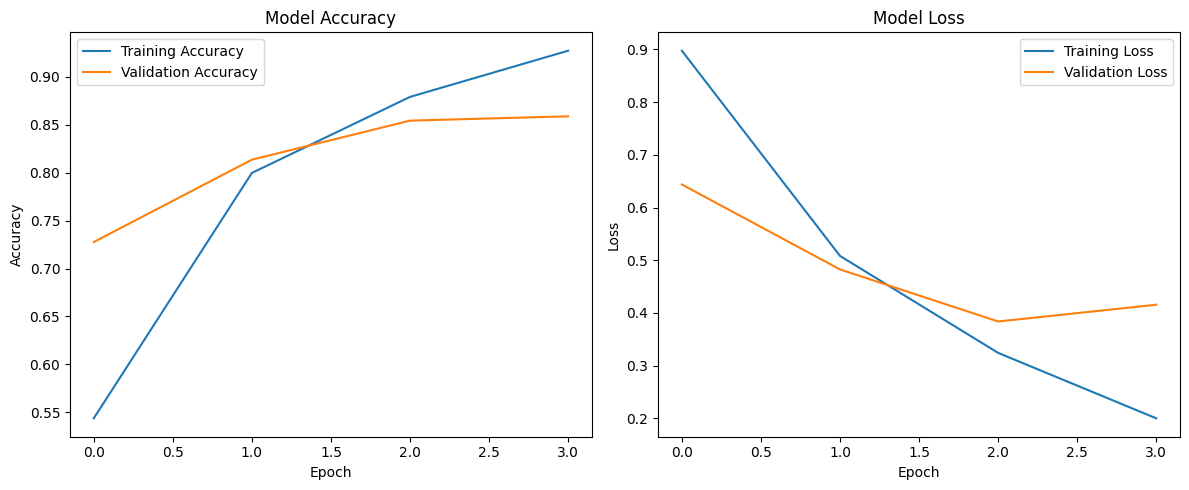

In [27]:
history = bert_classification_model_history.history

# Plotting accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1,2,2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
predictions_model= bert_classification_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask])
predictions_model = tf.argmax(predictions_model, axis=-1)
predictions_model

70/70 [==============================] - 21s 259ms/step


<tf.Tensor: shape=(2213,), dtype=int64, numpy=array([2, 2, 2, ..., 2, 2, 1])>

In [29]:
print(classification_report(y_test, predictions_model.numpy(),
                            target_names=['Left ','Center','Right']))

              precision    recall  f1-score   support

       Left        0.87      0.81      0.84       751
      Center       0.93      0.84      0.88       572
       Right       0.82      0.91      0.86       890

    accuracy                           0.86      2213
   macro avg       0.87      0.85      0.86      2213
weighted avg       0.86      0.86      0.86      2213



In [30]:
def plot_confusion_matrix(y_true, y_pred, label_names):
    cm = tf.math.confusion_matrix(y_true, y_pred)
    cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

    plt.figure(figsize=(20,7))
    sns.heatmap(
        cm, annot=True,
        xticklabels=label_names,
        yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")

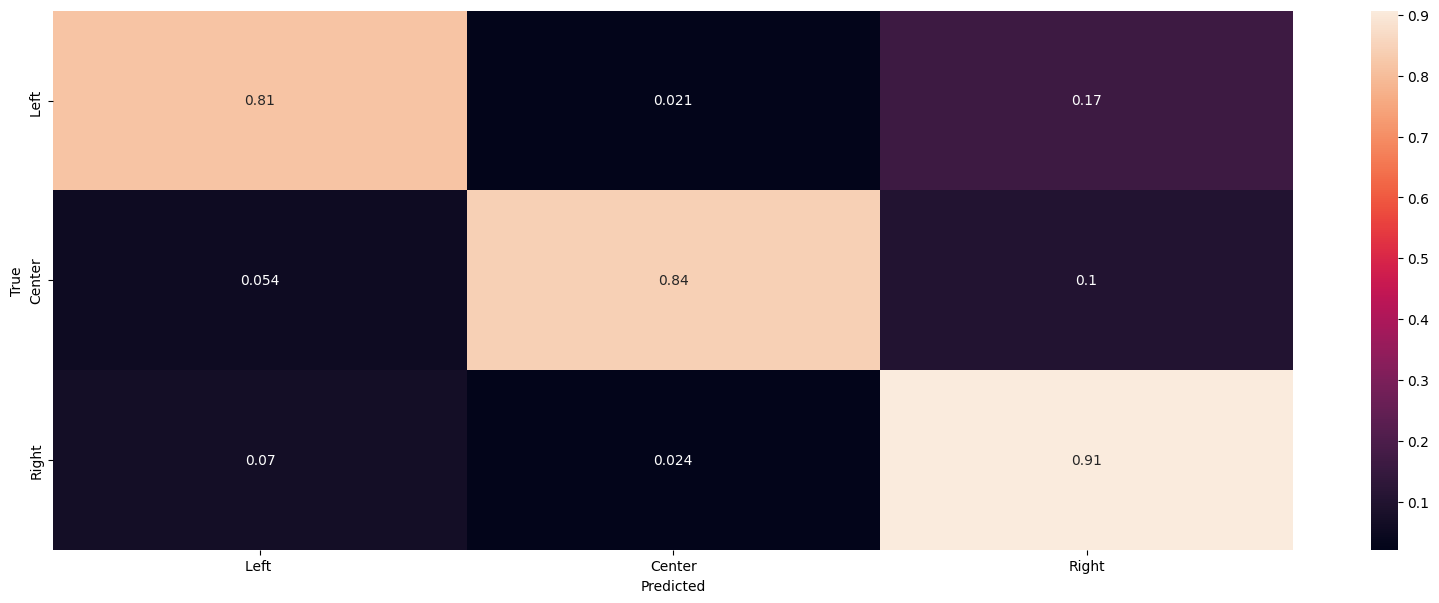

In [31]:
target_names=['Left ','Center','Right']
plot_confusion_matrix(y_test, predictions_model.numpy(), target_names)

In [32]:
bert_wrong_guesses = np.where(y_test != predictions_model.numpy())

In [33]:
print(f'Number of Wrong Guesses: ',len(bert_wrong_guesses[0]))

Number of Wrong Guesses:  312


In [34]:
#sampling 20 of the wrong precditions
wrong_guesses = [i for i in np.squeeze(bert_wrong_guesses[0])]
decoded_wrong_guesses_text=[]

for i in wrong_guesses[:]:
  decoded_text = bert_tokenizer.decode(x_test['input_ids'][i], skip_special_tokens=True)

  # print("Input text:")
  # print(decoded_text)
  decoded_wrong_guesses_text.append(decoded_text)
  # print("True label:")
  # print(y_test.iloc[i])
  # print("Predicted label:")
  # print(predictions_model.numpy()[i])

  # print("-" * 50)



In [35]:
len(decoded_wrong_guesses_text)

312

In [36]:
sources_analysis = test_df.loc[wrong_guesses]

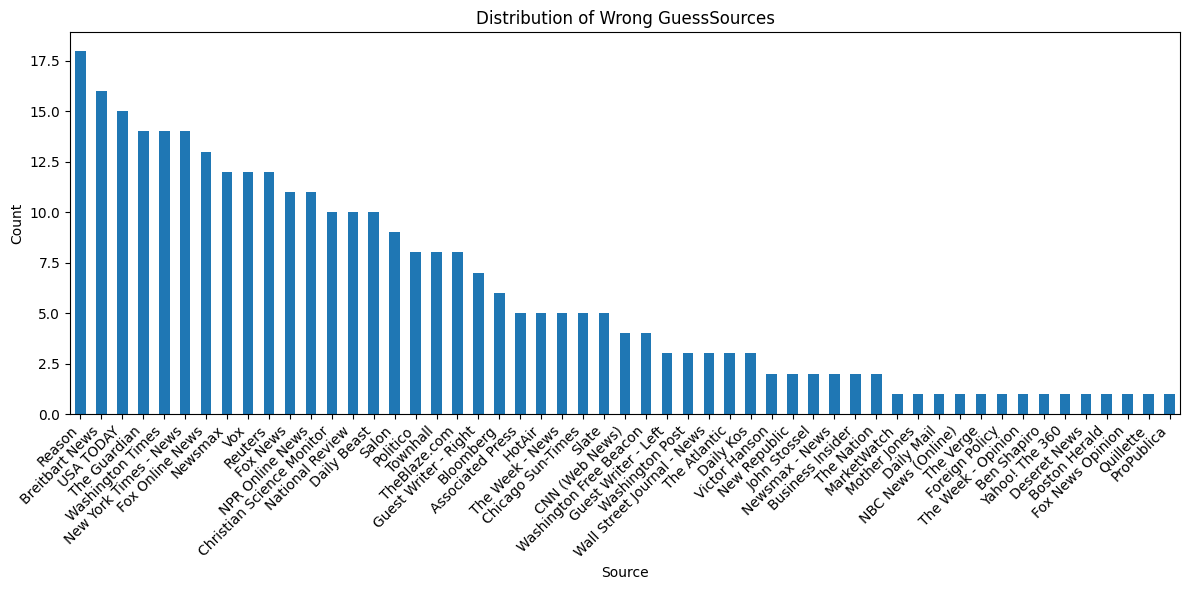

In [37]:
sources_analysis['source']
# Count the occurrences of each source
source_counts = sources_analysis['source'].value_counts()

# Create a bar plot
plt.figure(figsize=(12, 6))
source_counts.plot(kind='bar')

# Customize the plot
plt.title('Distribution of Wrong Guess''Sources')
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

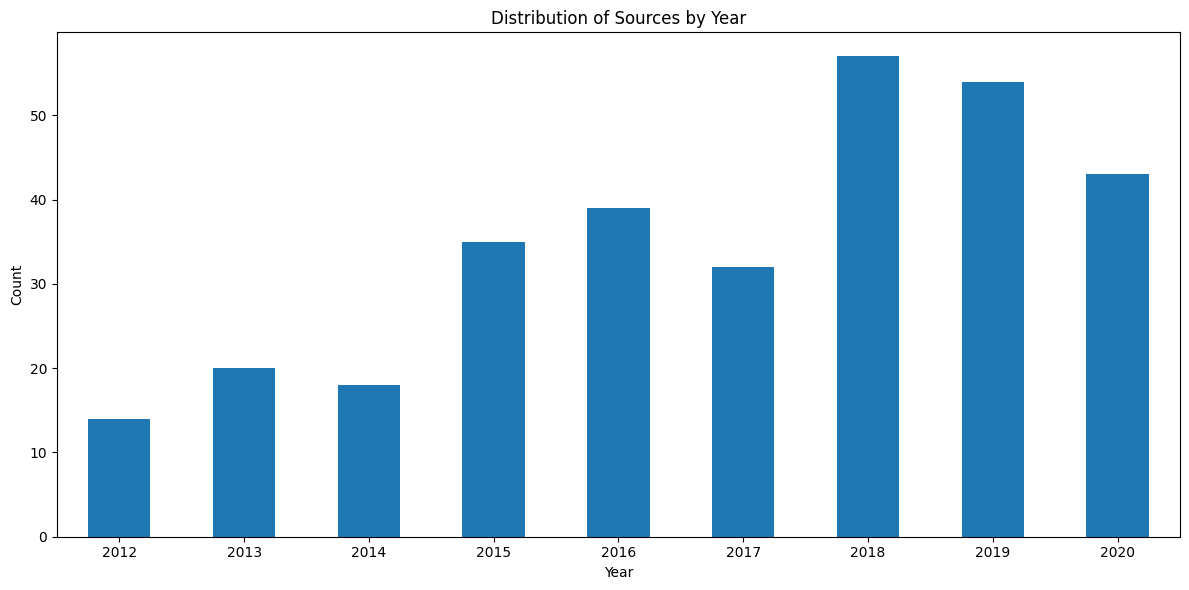

In [38]:
# Convert 'date' to datetime if it's not already
sources_analysis['date'] = pd.to_datetime(sources_analysis['date'])

# Extract year from the date
sources_analysis['year'] = sources_analysis['date'].dt.year

# Count occurrences of each year
year_counts = sources_analysis['year'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(12, 6))
year_counts.plot(kind='bar')

# Customize the plot
plt.title('Distribution of Sources by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=0)  # No rotation for years
plt.tight_layout()

# Show the plot
plt.show()

In [39]:
for i in wrong_guesses[:50]:
  decoded_text = bert_tokenizer.decode(x_test['input_ids'][i], skip_special_tokens=True)

  print("Input text:")
  print(decoded_text)
  print("True label:")
  print(y_test.iloc[i])
  print("Predicted label:")
  print(predictions_model.numpy()[i])

  print("-" * 50)


Input text:
in late june, barclays agreed pay $ 450 million resolve accusation tried manipulate rate benefit bottom line. shortly after, mr. diamond resigned position. in sign politicized scandal become, 11 member parliament recently signed resolution, naming mr. romney, called barclays executive cease fundraising political candidates ” focus rebuilding consumer confidence banking system. soliciting donation abroad, exotic sounds, mean new. election law permit candidate accept contribution citizen living outside united states, john mccain barack obama so. photo barclays ninthbiggest source contribution mr. romney ’ s campaign either directly joint fundraising effort republican national committee, according center responsive politics, employee contributing $ 234, 650 end may. but democrat may loath draw attention mr. romney ’ s donation big bank like barclays. employee bank contributed $ 34, 800 mr. obama joint effort democratic national committee. ( mr. obama allow registered lobbyist 

In [40]:
sources_analysis.to_csv('bert_fine_tuning (cls & filtered label)_wrong guess(7.26.24).csv', index=False)